In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions as dist
import matplotlib.pyplot as plt

from tqdm import tqdm

pd.set_option('display.max_columns', 500)

In [2]:
BALL_VARS = ['ballx', 'bally']
HOME_VARS = ['p1x', 'p1y', 'p2x', 'p2y', 'p3x', 'p3y', 'p4x', 'p4y', 'p5x', 'p5y', 'p6x', 'p6y', 'p7x', 'p7y', 'p8x', 'p8y', 'p9x', 'p9y', 'p10x', 'p10y', 'p11x', 'p11y']
AWAY_VARS = ['p12x', 'p12y', 'p13x', 'p13y', 'p14x', 'p14y', 'p15x', 'p15y', 'p16x', 'p16y', 'p17x', 'p17y', 'p18x', 'p18y', 'p19x', 'p19y', 'p20x', 'p20y', 'p21x', 'p21y', 'p22x', 'p22y']
FRAME_VARS = BALL_VARS + HOME_VARS + AWAY_VARS

In [3]:
N_CONTEXT_FRAMES = 3
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Loading data

In [4]:
data = pd.read_feather('data/tracking.feather')

In [5]:
features = []
for i in range(1, N_CONTEXT_FRAMES + 1):
    data_context = data.shift(i)
    data_context.loc[data_context['gameId'] != data['gameId'], FRAME_VARS] = pd.NA
    data_context = data_context[FRAME_VARS].add_prefix(f'c{i}_')
    data = pd.concat([data, data_context], axis=1)
    features += list(data_context.columns)
data = data.dropna()

In [6]:
data

,gameId,playId,frameId,ballx,bally,p1x,p1y,p2x,p2y,p3x,p3y,p4x,p4y,p5x,p5y,p6x,p6y,p7x,p7y,p8x,p8y,p9x,p9y,p10x,p10y,p11x,p11y,p12x,p12y,p13x,p13y,p14x,p14y,p15x,p15y,p16x,p16y,p17x,p17y,p18x,p18y,p19x,p19y,p20x,p20y,p21x,p21y,p22x,p22y,c1_ballx,c1_bally,c1_p1x,c1_p1y,c1_p2x,c1_p2y,c1_p3x,c1_p3y,c1_p4x,c1_p4y,c1_p5x,c1_p5y,c1_p6x,c1_p6y,c1_p7x,c1_p7y,c1_p8x,c1_p8y,c1_p9x,c1_p9y,c1_p10x,c1_p10y,c1_p11x,c1_p11y,c1_p12x,c1_p12y,c1_p13x,c1_p13y,c1_p14x,c1_p14y,c1_p15x,c1_p15y,c1_p16x,c1_p16y,c1_p17x,c1_p17y,c1_p18x,c1_p18y,c1_p19x,c1_p19y,c1_p20x,c1_p20y,c1_p21x,c1_p21y,c1_p22x,c1_p22y,c2_ballx,c2_bally,c2_p1x,c2_p1y,c2_p2x,c2_p2y,c2_p3x,c2_p3y,c2_p4x,c2_p4y,c2_p5x,c2_p5y,c2_p6x,c2_p6y,c2_p7x,c2_p7y,c2_p8x,c2_p8y,c2_p9x,c2_p9y,c2_p10x,c2_p10y,c2_p11x,c2_p11y,c2_p12x,c2_p12y,c2_p13x,c2_p13y,c2_p14x,c2_p14y,c2_p15x,c2_p15y,c2_p16x,c2_p16y,c2_p17x,c2_p17y,c2_p18x,c2_p18y,c2_p19x,c2_p19y,c2_p20x,c2_p20y,c2_p21x,c2_p21y,c2_p22x,c2_p22y,c3_ballx,c3_bally,c3_p1x,c3_p1y,c3_p2x,c3_p2y,c3_p3x,c3_p3y,c3_p4x,c3_p4y,c3_p5x,c3_p5y,c3_p6x,c3_p6y,c3_p7x,c3_p7y,c3_p8x,c3_p8y,c3_p9x,c3_p9y,c3_p10x,c3_p10y,c3_p11x,c3_p11y,c3_p12x,c3_p12y,c3_p13x,c3_p13y,c3_p14x,c3_p14y,c3_p15x,c3_p15y,c3_p16x,c3_p16y,c3_p17x,c3_p17y,c3_p18x,c3_p18y,c3_p19x,c3_p19y,c3_p20x,c3_p20y,c3_p21x,c3_p21y,c3_p22x,c3_p22y
3,2022090800,56,4,0.710000,0.556098,0.742917,0.553846,0.734833,0.564353,0.758417,0.517824,0.744917,0.538837,0.752917,0.539775,0.758250,0.551407,0.764083,0.531332,0.749500,0.619512,0.738667,0.584240,0.770083,0.513321,0.745333,0.595497,0.680167,0.538837,0.689750,0.563227,0.681750,0.456660,0.678417,0.621764,0.691667,0.617824,0.699000,0.548030,0.673917,0.469794,0.687250,0.546154,0.666167,0.506191,0.664250,0.620075,0.677750,0.568480,0.710000,0.556098,0.744000,0.553846,0.736500,0.565103,0.758667,0.522326,0.745833,0.539587,0.753333,0.543902,0.757833,0.550657,0.763917,0.533208,0.750667,0.616510,0.740250,0.583490,0.769750,0.520450,0.746917,0.593621,0.681083,0.537711,0.690000,0.561914,0.682417,0.458349,0.679000,0.618386,0.691750,0.615760,0.699000,0.547280,0.674250,0.472233,0.687333,0.545591,0.667333,0.507505,0.664833,0.617636,0.678500,0.567355,0.710083,0.556098,0.744917,0.553659,0.738250,0.565666,0.758833,0.527017,0.746750,0.540525,0.753750,0.547655,0.757583,0.550281,0.763833,0.535272,0.751833,0.613508,0.741667,0.582739,0.769250,0.527017,0.748417,0.592120,0.681917,0.536398,0.690417,0.560788,0.683083,0.459850,0.679500,0.615197,0.691917,0.613696,0.699000,0.546717,0.674583,0.474859,0.687583,0.545028,0.668500,0.508818,0.665500,0.615197,0.679250,0.566229,0.710083,0.556098,0.745667,0.553846,0.740000,0.566417,0.759000,0.531707,0.747667,0.541651,0.754167,0.551407,0.757333,0.549906,0.763667,0.537148,0.753000,0.610507,0.743083,0.581989,0.768750,0.533208,0.749667,0.590807,0.682750,0.535084,0.690833,0.559850,0.683750,0.461351,0.680000,0.611820,0.692083,0.611632,0.698917,0.545966,0.675000,0.477298,0.687917,0.544653,0.669583,0.509944,0.666167,0.612758,0.679833,0.564728
4,2022090800,56,5,0.710000,0.556098,0.741667,0.553659,0.733250,0.563602,0.758083,0.513508,0.743833,0.538086,0.752500,0.535835,0.758500,0.551782,0.764167,0.529268,0.748333,0.622514,0.737083,0.584991,0.770333,0.506004,0.743667,0.597186,0.679167,0.539962,0.689500,0.564728,0.681083,0.455159,0.677833,0.625141,0.691500,0.620263,0.698917,0.548405,0.673667,0.467542,0.687333,0.546717,0.665083,0.505066,0.663667,0.622702,0.676917,0.569231,0.710000,0.556098,0.742917,0.553846,0.734833,0.564353,0.758417,0.517824,0.744917,0.538837,0.752917,0.539775,0.758250,0.551407,0.764083,0.531332,0.749500,0.619512,0.738667,0.584240,0.770083,0.513321,0.745333,0.595497,0.680167,0.538837,0.689750,0.563227,0.681750,0.456660,0.678417,0.621764,0.691667,0.617824,0.699000,0.548030,0.673917,0.469794,0.687250,0.546154,0.666167,0.506191,0.664250,0.620075,0.677750,0.568480,0.710000,0.556098,0.744000,0.553846,0.736500,0.565103,0.758667,0.522326,0.745833,0.539587,0.753333,0.543902,0.757833,0.550657,0.763917,0.533208,0.750667,0.616510,0.740250,0.583490,0.76975

In [7]:
print(features)

['c1_ballx', 'c1_bally', 'c1_p1x', 'c1_p1y', 'c1_p2x', 'c1_p2y', 'c1_p3x', 'c1_p3y', 'c1_p4x', 'c1_p4y', 'c1_p5x', 'c1_p5y', 'c1_p6x', 'c1_p6y', 'c1_p7x', 'c1_p7y', 'c1_p8x', 'c1_p8y', 'c1_p9x', 'c1_p9y', 'c1_p10x', 'c1_p10y', 'c1_p11x', 'c1_p11y', 'c1_p12x', 'c1_p12y', 'c1_p13x', 'c1_p13y', 'c1_p14x', 'c1_p14y', 'c1_p15x', 'c1_p15y', 'c1_p16x', 'c1_p16y', 'c1_p17x', 'c1_p17y', 'c1_p18x', 'c1_p18y', 'c1_p19x', 'c1_p19y', 'c1_p20x', 'c1_p20y', 'c1_p21x', 'c1_p21y', 'c1_p22x', 'c1_p22y', 'c2_ballx', 'c2_bally', 'c2_p1x', 'c2_p1y', 'c2_p2x', 'c2_p2y', 'c2_p3x', 'c2_p3y', 'c2_p4x', 'c2_p4y', 'c2_p5x', 'c2_p5y', 'c2_p6x', 'c2_p6y', 'c2_p7x', 'c2_p7y', 'c2_p8x', 'c2_p8y', 'c2_p9x', 'c2_p9y', 'c2_p10x', 'c2_p10y', 'c2_p11x', 'c2_p11y', 'c2_p12x', 'c2_p12y', 'c2_p13x', 'c2_p13y', 'c2_p14x', 'c2_p14y', 'c2_p15x', 'c2_p15y', 'c2_p16x', 'c2_p16y', 'c2_p17x', 'c2_p17y', 'c2_p18x', 'c2_p18y', 'c2_p19x', 'c2_p19y', 'c2_p20x', 'c2_p20y', 'c2_p21x', 'c2_p21y', 'c2_p22x', 'c2_p22y', 'c3_ballx', 'c3_bal

In [8]:
train_data = data[data['gameId'] < 2022101700]
val_data = data[(data['gameId'] >= 2022101700) & (data['gameId'] < 2022102400)]
test_data = data[data['gameId'] >= 2022102400]

# Modeling

In [9]:
# MDN Model Definition
class MDN(nn.Module):
    def __init__(self, input_dim, n_points, n_gaussians):
        super(MDN, self).__init__()

        self.n_points = n_points
        self.n_gaussians = n_gaussians

        self.fc1 = nn.Linear(input_dim, 1024)
        self.dropout1 = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(1024, 1024)
        self.dropout2 = nn.Dropout(p=0.2)
        # self.fc3 = nn.Linear(1024, 1024)
        # self.dropout3 = nn.Dropout(p=0.2)
        self.fc_mu = nn.Linear(1024, n_points * n_gaussians * 2)   # Means
        self.fc_sigma = nn.Linear(1024, n_points * n_gaussians * 2) # Std deviations
        self.fc_pi = nn.Linear(1024, n_points * n_gaussians)        # Mixture weights

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        # x = torch.relu(self.fc3(x))
        # x = self.dropout3(x)
        mu = self.fc_mu(x).view(-1, self.n_points, self.n_gaussians, 2)
        sigma = F.softplus(self.fc_sigma(x)).view(-1, self.n_points, self.n_gaussians, 2)# + 1e-6
        pi = torch.softmax(self.fc_pi(x).view(-1, self.n_points, self.n_gaussians), dim=-1)
        return mu, sigma, pi

# Loss function
def mdn_nll_loss(y, mu, sigma, pi):
    m = dist.Normal(mu, sigma)
    log_prob = m.log_prob(y.unsqueeze(2))  # Add Gaussian components dimension
    log_prob = torch.sum(log_prob, dim=-1) # Sum over x and y dimensions
    weighted_log_prob = log_prob + torch.log(pi)
    nll = -torch.logsumexp(weighted_log_prob, dim=-1)  # Log-sum-exp over gaussians
    return nll.mean()

# Sampling function
def sample_from_mdn(mu, sigma, pi, n_samples=1):
    batch_size, n_points, n_gaussians, _ = mu.shape
    samples = []
    
    for b in range(batch_size):
        point_samples = []
        for p in range(n_points):
            # Sample component
            categorical = dist.Categorical(pi[b, p])
            component = categorical.sample((n_samples,))
            
            # Sample from Gaussian
            chosen_mu = mu[b, p, component, :]
            chosen_sigma = sigma[b, p, component, :]
            normal_dist = dist.Normal(chosen_mu, chosen_sigma)
            
            # Sample n_samples from selected Gaussian component
            point_samples.append(normal_dist.sample())
        
        samples.append(torch.stack(point_samples).squeeze(1))
    
    return torch.stack(samples)  # Shape: (batch_size, n_points, n_samples, 2)

In [10]:
len(features)

138

In [11]:
# Parameters
n_points = 23 # 23 elements on the field
input_dim = n_points * 2 * N_CONTEXT_FRAMES # Flattened x, y coordinates of all points * number of context frames
n_gaussians = 3 # Number of mixture components
output_dim = 11 * 2 * 2 * n_gaussians # 11 players * 2 teams * 2 coordinates * n_gaussians per point

In [12]:
x_train = torch.tensor(train_data[features].values, dtype=torch.float32).to(DEVICE)
y_train = torch.tensor(train_data[FRAME_VARS].values, dtype=torch.float32).view(-1, n_points, 2).to(DEVICE)
x_val = torch.tensor(val_data[features].values, dtype=torch.float32).to(DEVICE)
y_val = torch.tensor(val_data[FRAME_VARS].values, dtype=torch.float32).view(-1, n_points, 2).to(DEVICE)

train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
val_dataset = torch.utils.data.TensorDataset(x_val, y_val)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1024, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1024, shuffle=False)

In [13]:
# Training the model
model = MDN(input_dim=input_dim, n_points=n_points, n_gaussians=n_gaussians).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.001)
n_epochs = 20

In [14]:
for epoch in range(n_epochs):
    for x_train, y_train in tqdm(train_loader):
        optimizer.zero_grad()
        mu, sigma, pi = model(x_train)
        loss = mdn_nll_loss(y_train, mu, sigma, pi)
        loss.backward()
        optimizer.step()
    if ((epoch % 1)) == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

100%|██████████| 1722/1722 [00:17<00:00, 98.79it/s] 


Epoch 0, Loss: -3.4580


100%|██████████| 1722/1722 [00:16<00:00, 103.96it/s]


Epoch 1, Loss: -3.8525


100%|██████████| 1722/1722 [00:16<00:00, 101.42it/s]


Epoch 2, Loss: -3.9222


100%|██████████| 1722/1722 [00:16<00:00, 101.99it/s]


Epoch 3, Loss: -3.9984


100%|██████████| 1722/1722 [00:16<00:00, 103.71it/s]


Epoch 4, Loss: -4.1259


100%|██████████| 1722/1722 [00:16<00:00, 101.99it/s]


Epoch 5, Loss: -4.2299


100%|██████████| 1722/1722 [00:16<00:00, 103.49it/s]


Epoch 6, Loss: -4.2258


100%|██████████| 1722/1722 [00:16<00:00, 102.80it/s]


Epoch 7, Loss: -4.0438


100%|██████████| 1722/1722 [00:16<00:00, 103.93it/s]


Epoch 8, Loss: -4.3130


100%|██████████| 1722/1722 [00:16<00:00, 102.96it/s]


Epoch 9, Loss: -4.4180


100%|██████████| 1722/1722 [00:17<00:00, 99.03it/s] 


Epoch 10, Loss: -4.4455


100%|██████████| 1722/1722 [00:16<00:00, 104.63it/s]


Epoch 11, Loss: -4.4681


100%|██████████| 1722/1722 [00:16<00:00, 104.60it/s]


Epoch 12, Loss: -4.4411


100%|██████████| 1722/1722 [00:16<00:00, 103.97it/s]


Epoch 13, Loss: -4.5025


100%|██████████| 1722/1722 [00:16<00:00, 101.45it/s]


Epoch 14, Loss: -4.5106


100%|██████████| 1722/1722 [00:16<00:00, 104.41it/s]


Epoch 15, Loss: -4.4297


100%|██████████| 1722/1722 [00:16<00:00, 101.53it/s]


Epoch 16, Loss: -4.5043


100%|██████████| 1722/1722 [00:17<00:00, 99.66it/s] 


Epoch 17, Loss: -4.5336


100%|██████████| 1722/1722 [00:16<00:00, 103.10it/s]


Epoch 18, Loss: -4.5278


100%|██████████| 1722/1722 [00:16<00:00, 104.66it/s]

Epoch 19, Loss: -4.4091


# Plotting

In [15]:
play_data = train_data[(train_data['gameId'] == 2022090800) & (train_data['playId'] == 56)]
play_data.shape

(189, 187)

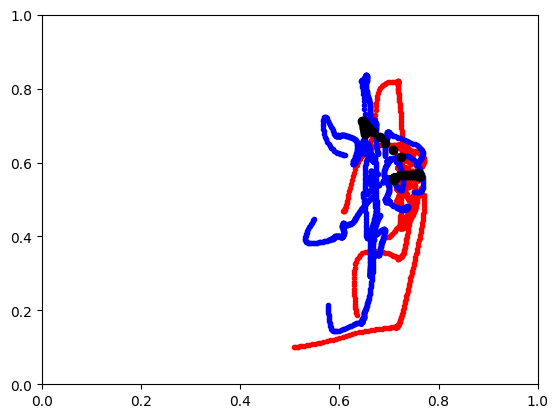

In [16]:
for i in range(1, 23):
    plt.plot(play_data[f'p{i}x'], play_data[f'p{i}y'], '.', color='red' if i <= 11 else 'blue')
plt.plot(play_data['ballx'], play_data['bally'], 'o', color='black')
plt.xlim(0, 1);
plt.ylim(0, 1);

In [27]:
frames = []

current_frame = play_data.iloc[0][features].values
for i in range(189):
    x = torch.tensor(current_frame, dtype=torch.float32).to(DEVICE).unsqueeze(0)
    mu, sigma, pi = model(x)
    samples = sample_from_mdn(mu, sigma, pi, n_samples=1).squeeze(2).detach().cpu().numpy()
    frames.append(samples.flatten())
    current_frame = np.concatenate([samples.flatten(), current_frame[:-2 * n_points]])
frames = pd.DataFrame(frames, columns=FRAME_VARS)

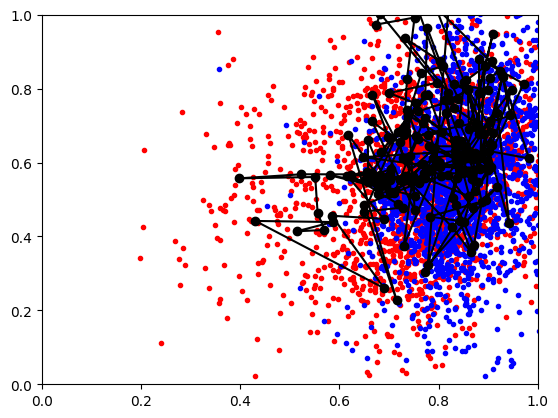

In [23]:
for i in range(1, 23):
    plt.plot(frames[f'p{i}x'], frames[f'p{i}y'], '.', color='red' if i <= 11 else 'blue')
plt.plot(frames['ballx'], frames['bally'], color='black', marker='o')
plt.xlim(0, 1);
plt.ylim(0, 1);

In [29]:
current_frame = play_data.iloc[0][features].values
x = torch.tensor(current_frame, dtype=torch.float32).to(DEVICE).unsqueeze(0)
mu, sigma, pi = model(x)
mu.flatten()

tensor([0.7194, 0.5678, 0.7002, 0.5949, 0.6915, 0.5573, 0.7757, 0.5286, 0.7629,
        0.5756, 0.7418, 0.5784, 0.7462, 0.5791, 0.7715, 0.5780, 0.7456, 0.5702,
        0.7556, 0.5413, 0.7881, 0.5280, 0.7502, 0.5607, 0.7807, 0.5710, 0.7905,
        0.4635, 0.7510, 0.5606, 0.7699, 0.5541, 0.7529, 0.5432, 0.8035, 0.5070,
        0.7629, 0.5636, 0.7676, 0.5762, 0.7484, 0.5368, 0.7701, 0.5225, 0.7793,
        0.5174, 0.8274, 0.4971, 0.7633, 0.5990, 0.8003, 0.6383, 0.7684, 0.6090,
        0.7508, 0.5771, 0.7325, 0.6036, 0.7532, 0.5933, 0.7894, 0.5459, 0.7836,
        0.5409, 0.7857, 0.5288, 0.7707, 0.5428, 0.7576, 0.5722, 0.7557, 0.5372,
        0.6908, 0.5245, 0.6709, 0.5504, 0.6945, 0.5521, 0.6911, 0.5396, 0.7199,
        0.5648, 0.6967, 0.5589, 0.6983, 0.4700, 0.6401, 0.4937, 0.7184, 0.5023,
        0.6339, 0.5232, 0.6819, 0.6710, 0.7028, 0.6820, 0.7069, 0.6690, 0.6646,
        0.4765, 0.6893, 0.6197, 0.7080, 0.5852, 0.7030, 0.5623, 0.6989, 0.6070,
        0.6444, 0.4938, 0.6831, 0.4740, 

In [30]:
current_frame.round(4)

array([0.71  , 0.5561, 0.744 , 0.5538, 0.7365, 0.5651, 0.7587, 0.5223,
       0.7458, 0.5396, 0.7533, 0.5439, 0.7578, 0.5507, 0.7639, 0.5332,
       0.7507, 0.6165, 0.7402, 0.5835, 0.7698, 0.5205, 0.7469, 0.5936,
       0.6811, 0.5377, 0.69  , 0.5619, 0.6824, 0.4583, 0.679 , 0.6184,
       0.6918, 0.6158, 0.699 , 0.5473, 0.6742, 0.4722, 0.6873, 0.5456,
       0.6673, 0.5075, 0.6648, 0.6176, 0.6785, 0.5674, 0.7101, 0.5561,
       0.7449, 0.5537, 0.7383, 0.5657, 0.7588, 0.527 , 0.7468, 0.5405,
       0.7538, 0.5477, 0.7576, 0.5503, 0.7638, 0.5353, 0.7518, 0.6135,
       0.7417, 0.5827, 0.7692, 0.527 , 0.7484, 0.5921, 0.6819, 0.5364,
       0.6904, 0.5608, 0.6831, 0.4598, 0.6795, 0.6152, 0.6919, 0.6137,
       0.699 , 0.5467, 0.6746, 0.4749, 0.6876, 0.545 , 0.6685, 0.5088,
       0.6655, 0.6152, 0.6792, 0.5662, 0.7101, 0.5561, 0.7457, 0.5538,
       0.74  , 0.5664, 0.759 , 0.5317, 0.7477, 0.5417, 0.7542, 0.5514,
       0.7573, 0.5499, 0.7637, 0.5371, 0.753 , 0.6105, 0.7431, 0.582 ,
      

In [31]:
sigma.flatten()

tensor([0.0127, 0.0123, 0.0611, 0.1577, 0.0302, 0.0036, 0.0493, 0.0766, 0.0165,
        0.0180, 0.0318, 0.0137, 0.0343, 0.0393, 0.0080, 0.0130, 0.0156, 0.0234,
        0.0154, 0.0266, 0.0380, 0.0415, 0.0096, 0.0195, 0.0145, 0.0299, 0.0947,
        0.1135, 0.0135, 0.0248, 0.0278, 0.0268, 0.0143, 0.0248, 0.0813, 0.0914,
        0.0146, 0.0250, 0.0227, 0.0290, 0.1137, 0.1059, 0.0138, 0.0260, 0.0192,
        0.0281, 0.0845, 0.0853, 0.0146, 0.0266, 0.0135, 0.0216, 0.0480, 0.0519,
        0.0149, 0.0282, 0.0710, 0.0948, 0.0367, 0.0291, 0.0492, 0.0477, 0.0146,
        0.0258, 0.0102, 0.0217, 0.0488, 0.0552, 0.0152, 0.0274, 0.0093, 0.0152,
        0.0599, 0.0863, 0.0230, 0.0271, 0.0145, 0.0211, 0.0619, 0.0708, 0.0208,
        0.0263, 0.0166, 0.0238, 0.0146, 0.0267, 0.0881, 0.0957, 0.0165, 0.0289,
        0.0946, 0.1358, 0.0144, 0.0234, 0.0110, 0.0237, 0.0170, 0.0260, 0.0741,
        0.0892, 0.0152, 0.0244, 0.0429, 0.0435, 0.0155, 0.0238, 0.0072, 0.0176,
        0.0256, 0.0326, 0.0154, 0.0241, 

In [36]:
mu.flatten().detach().cpu().numpy() - current_frame.round(4)

array([ 0.00936285,  0.01167316, -0.04380302,  0.04108654, -0.04502604,
       -0.00781439,  0.01695348,  0.00634414,  0.01713957,  0.03603365,
       -0.01146619,  0.03451444, -0.01158454,  0.02838559,  0.00755731,
        0.04480668, -0.00512445, -0.04628489,  0.01538913, -0.04222223,
        0.01829249,  0.00752014,  0.00332137, -0.03293272,  0.09956826,
        0.03331977,  0.10053605, -0.09839253,  0.06860923,  0.10229617,
        0.09093465, -0.06429591,  0.0610823 , -0.07257024,  0.10448134,
       -0.04033621,  0.08869219,  0.09142903,  0.08026263,  0.03055507,
        0.08106582,  0.02932417,  0.10525374, -0.09512762,  0.10078782,
       -0.05003508,  0.11727249, -0.05903612,  0.0184335 ,  0.04525122,
        0.06204918,  0.07259142,  0.00960389,  0.08196409,  0.00396568,
        0.03661381, -0.02128252,  0.05589716, -0.00440996,  0.04296136,
        0.02560791,  0.01059832,  0.03178501, -0.07260579,  0.04403298,
       -0.05393307,  0.00151118,  0.01583404,  0.00920818, -0.01